# 5. Training 
 --------------------------------------------------------------------

Train a model using a snapshot of the data.

![Model deployment with streaming Real-time operational Pipeline](../../assets/images/model-deployment-with-streaming.png)

## Step 1: Create and Configure a New Project <a id="gs-step-project-create-n-config"></a>

### Create a New Project <a id="gs-create-project"></a>

In [1]:
from os import path, getenv
from mlrun import new_project

project_name = '-'.join(filter(None, ['rapid-prototype', getenv('V3IO_USERNAME', None)]))
project_path = path.abspath('conf')
project = new_project(project_name, project_path, init_git=True)

print(f'Project path: {project_path}\nProject name: {project_name}')

Project path: /User/rapid-proto/conf
Project name: rapid-prototype-michaelk


### Configure MLRun <a id="gs-mlrun-config"></a>

In [2]:
from mlrun import run_local, NewTask, mlconf, import_function, mount_v3io

# Target location for storing pipeline artifacts
artifact_path = path.abspath('artifacts')
# MLRun DB path or API service URL
mlconf.dbpath = mlconf.dbpath or 'http://mlrun-api:8080'

print(f'Artifacts path: {artifact_path}\nMLRun DB path: {mlconf.dbpath}')

Artifacts path: /User/rapid-proto/artifacts
MLRun DB path: http://mlrun-api:8080


#### Import Nuclio <a id="gs-nuclio-import"></a>


In [3]:
import nuclio

In [4]:
# nuclio: start-code

In [5]:
%nuclio config spec.build.baseImage = "mlrun/ml-models"
%nuclio config kind = "job"
%nuclio cmd -c pip install v3io-frames==0.6.18

%nuclio: setting spec.build.baseImage to 'mlrun/ml-models'
%nuclio: setting kind to 'job'


## Step 2: Take a Snapshot Data Set of the KV feature table <a id="gs-step-ingest-data"></a>


### Initialization <a id="gs-step-ingest-data-init"></a>


In [6]:
# nuclio: ignore
# Set the source-data URL
container = 'users'
table_path = path.join(getenv('V3IO_USERNAME'),'examples/rapid-prototype/feature-table')
columns = ['label', 'socioeconomic_idx', 
           'purchase_sum', 'purchase_mean', 'purchase_count', 'purchase_var', 
           'bet_sum', 'bet_mean', 'bet_count' ,'bet_var',
           'win_sum', 'win_mean', 'win_count' ,'win_var']
format = 'csv'

### Define a Data-Snapshot Function <a id="gs-step-ingest-data-define-function"></a>


In [7]:
from os import path
import pandas as pd
import v3io_frames as v3f


# Ingest a data set into the platform
def snapshot_data(context, container, table_path, columns, format='csv'):
    
    client = v3f.Client("framesd:8081", container=container)
    client.execute(backend="kv", table=table_path, command="infer")
    df = client.read('kv', table_path, columns=columns)
    
    target_path = path.join(context.artifact_path, 'data')
    # Optionally print data to your logger
    context.logger.info('Saving snapshot data set to {} ...'.format(target_path))
    
    # Store the data set in your artifacts database
    context.log_dataset('snapshot_dataset', df=df, format=format,
                        index=False, artifact_path=target_path)

In [8]:
# nuclio: end-code

<a id='gs-run-ingest-func-local'></a>
#### Run the Function Locally in Jupyter Notebook

In [9]:
# Run the data-ingestion function locally in Jupyter Notebook
snapshot_data_run = run_local(name='snapshot_data',
                         handler=snapshot_data,
                         params={'container': container, 'table_path': table_path, 
                                 'columns':columns, 'format': format},
                         project=project_name, artifact_path=artifact_path)

> 2020-08-03 16:24:43,140 [info] starting run snapshot_data uid=d6b19374c5a7428186f66ba8116fe954  -> http://mlrun-api:8080
> 2020-08-03 16:24:43,434 [info] Saving snapshot data set to /User/rapid-proto/artifacts/data ...


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
rapid-prototype-michaelk,...116fe954,0,Aug 03 16:24:43,completed,snapshot_data,v3io_user=michaelkkind=handlerowner=michaelkhost=jupyter-mk-7c7fc6cc67-fkkvj,,"container=userstable_path=michaelk/examples/rapid-prototype/feature-tablecolumns=['label', 'socioeconomic_idx', 'purchase_sum', 'purchase_mean', 'purchase_count', 'purchase_var', 'bet_sum', 'bet_mean', 'bet_count', 'bet_var', 'win_sum', 'win_mean', 'win_count', 'win_var']format=csv",,snapshot_dataset


to track results use .show() or .logs() or in CLI: 
!mlrun get run d6b19374c5a7428186f66ba8116fe954 --project rapid-prototype-michaelk , !mlrun logs d6b19374c5a7428186f66ba8116fe954 --project rapid-prototype-michaelk
> 2020-08-03 16:24:43,672 [info] run executed, status=completed


#### Run the Function on a Cluster <a id="gs-run-ingest-func-cluster"></a>


In [10]:
from mlrun import code_to_function

# Convert the local snapshot_data function into a gen_func project function
gen_func = code_to_function(name='snapshot-data')
project.set_function(gen_func)
snapshot_data_func = project.func('snapshot-data').apply(mount_v3io())

In [11]:
#Build image
snapshot_data_func.deploy()

> 2020-07-30 13:17:19,346 [info] starting remote build, image: .mlrun/func-rapid-prototype-michaelk-snapshot-data-latest
INFO[0000] Resolved base name mlrun/ml-models:0.5.1-rc1 to mlrun/ml-models:0.5.1-rc1 
INFO[0000] Resolved base name mlrun/ml-models:0.5.1-rc1 to mlrun/ml-models:0.5.1-rc1 
INFO[0000] Retrieving image manifest mlrun/ml-models:0.5.1-rc1 
INFO[0002] Retrieving image manifest mlrun/ml-models:0.5.1-rc1 
INFO[0004] Built cross stage deps: map[]                
INFO[0004] Retrieving image manifest mlrun/ml-models:0.5.1-rc1 
INFO[0005] Retrieving image manifest mlrun/ml-models:0.5.1-rc1 
INFO[0006] Unpacking rootfs as cmd RUN pip install v3io-frames==0.6.18 requires it. 
INFO[0153] Taking snapshot of full filesystem...        
INFO[0159] Resolving paths                              
INFO[0182] RUN pip install v3io-frames==0.6.18          
INFO[0182] cmd: /bin/sh                                 
INFO[0182] args: [-c pip install v3io-frames==0.6.18]   
INFO[0189] Taking snapsh

True

##### Run the Function on the Cluster <a id="gs-run-ingest-func-on-the-cluster-run-function"></a>


In [11]:

snapshot_data_run = snapshot_data_func.run(name='snapshot_data',
                                 handler='snapshot_data',
                                 params={'container': container, 'table_path': table_path, 
                                         'columns':columns, 'format': format},
                                 artifact_path=artifact_path)

> 2020-08-03 16:25:44,440 [info] starting run snapshot_data uid=dd998a2a259f44abbbbabe252954a857  -> http://mlrun-api:8080
> 2020-08-03 16:25:44,616 [info] Job is running in the background, pod: snapshot-data-tx4ht
> 2020-08-03 16:25:50,285 [warning] warning!, server (0.5.1) and client (0.5.1-rc1) ver dont match
> 2020-08-03 16:25:50,371 [warning] warning!, server (0.5.1) and client (0.5.1-rc1) ver dont match
> 2020-08-03 16:25:50,667 [info] Saving snapshot data set to /User/rapid-proto/artifacts/data ...
> 2020-08-03 16:25:50,892 [info] run executed, status=completed
final state: succeeded


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
rapid-prototype-michaelk,...2954a857,0,Aug 03 16:25:50,completed,snapshot_data,v3io_user=michaelkkind=jobowner=michaelkhost=snapshot-data-tx4ht,,"container=userstable_path=michaelk/examples/rapid-prototype/feature-tablecolumns=['label', 'socioeconomic_idx', 'purchase_sum', 'purchase_mean', 'purchase_count', 'purchase_var', 'bet_sum', 'bet_mean', 'bet_count', 'bet_var', 'win_sum', 'win_mean', 'win_count', 'win_var']format=csv",,snapshot_dataset


to track results use .show() or .logs() or in CLI: 
!mlrun get run dd998a2a259f44abbbbabe252954a857 --project rapid-prototype-michaelk , !mlrun logs dd998a2a259f44abbbbabe252954a857 --project rapid-prototype-michaelk
> 2020-08-03 16:25:53,867 [info] run executed, status=completed


## Step 3: Explore the Data <a id="gs-step-explore-data"></a>


### Explore the Data with Pandas DataFrames <a id="gs-explore-data-w-pandas-df"></a>


Run the following code to use pandas DataFrames to read your data set, extract some basic statistics, and display them.

In [12]:
# Read your data set
from mlrun.run import get_dataitem
df = get_dataitem(snapshot_data_run.outputs['snapshot_dataset']).as_df()

In [13]:
# Display a portion of the read data
df.head()

,label,socioeconomic_idx,purchase_sum,purchase_mean,purchase_count,purchase_var,bet_sum,bet_mean,bet_count,bet_var,win_sum,win_mean,win_count,win_var
0,1,4,5643,50,115,143,8062,10,860,6,2224.0,202.0,11.0,1619.0
1,1,4,3979,50,81,131,8599,7,899,12,2190.0,220.0,10.0,2076.0
2,1,1,5293,51,105,154,7583,11,801,7,1132.0,188.0,6.0,1918.0
3,1,2,3671,47,75,123,5956,8,636,7,1730.0,214.0,8.0,1922.0
4,0,5,2047,50,39,131,3528,12,368,11,6334.0,194.0,33.0,2405.0


In [14]:
# Calculate and display the number of data-set items
print(f'Total number of rows: {len(df)}')

Total number of rows: 2675


In [15]:
# Display statistics grouped by label
df.groupby(['label']).describe()

socioeconomic_idx                                               \
                  count      mean       std  min  25%  50%  75%  max   
label                                                                  
0                 601.0  5.023295  1.830152  1.0  4.0  5.0  6.0  7.0   
1                2074.0  2.984571  1.677510  1.0  2.0  3.0  4.0  7.0   

      purchase_sum               ... win_count       win_var               \
             count         mean  ...       75%   max   count         mean   
label                            ...                                        
0            601.0  1879.836938  ...      28.0  63.0   586.0  2101.607509   
1           2074.0  4548.985535  ...      11.0  22.0  2071.0  2199.506036   

                                                         
              std  min     25%     50%      75%     max  
label                                                    
0      841.272875  0.0  1760.0  2114.5  2499.75  6170.0  
1      840.572416  0.0  1672.0  2183.0  2686.50  6498.0  

[2 rows x 104 columns]

### Explore the Data with an MLRun Marketplace Function <a id="gs-explore-data-w-mlrun-func"></a>


#### Add an Exploration Function <a id="gs-explore-data-w-mlrun-func-add-func"></a>


In [16]:
project.set_function('hub://describe', 'describe')
describe = project.func('describe').apply(mount_v3io())

#### Run the Exploration Function <a id="gs-explore-data-w-mlrun-func-run-func"></a>


In [17]:
describe_run = describe.run(params={'label_column': 'label'},
                            inputs={"table":
                                    snapshot_data_run.outputs['snapshot_dataset']},
                            artifact_path=artifact_path)

> 2020-08-03 16:26:36,661 [info] starting run describe-summarize uid=d8ab11dd21374ff192c1389eb420e06d  -> http://mlrun-api:8080
> 2020-08-03 16:26:36,882 [info] Job is running in the background, pod: describe-summarize-5t98g
> 2020-08-03 16:28:40,797 [info] run executed, status=completed
final state: succeeded


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
rapid-prototype-michaelk,...b420e06d,0,Aug 03 16:27:50,completed,describe-summarize,v3io_user=michaelkkind=jobowner=michaelkhost=describe-summarize-5t98g,table,label_column=label,,histogramsviolinimbalanceimbalance-weights-veccorrelation-matrixcorrelation


to track results use .show() or .logs() or in CLI: 
!mlrun get run d8ab11dd21374ff192c1389eb420e06d --project rapid-prototype-michaelk , !mlrun logs d8ab11dd21374ff192c1389eb420e06d --project rapid-prototype-michaelk
> 2020-08-03 16:28:46,751 [info] run executed, status=completed


#### Review the Run Output <a id="gs-explore-data-w-mlrun-func-run-output-review"></a>



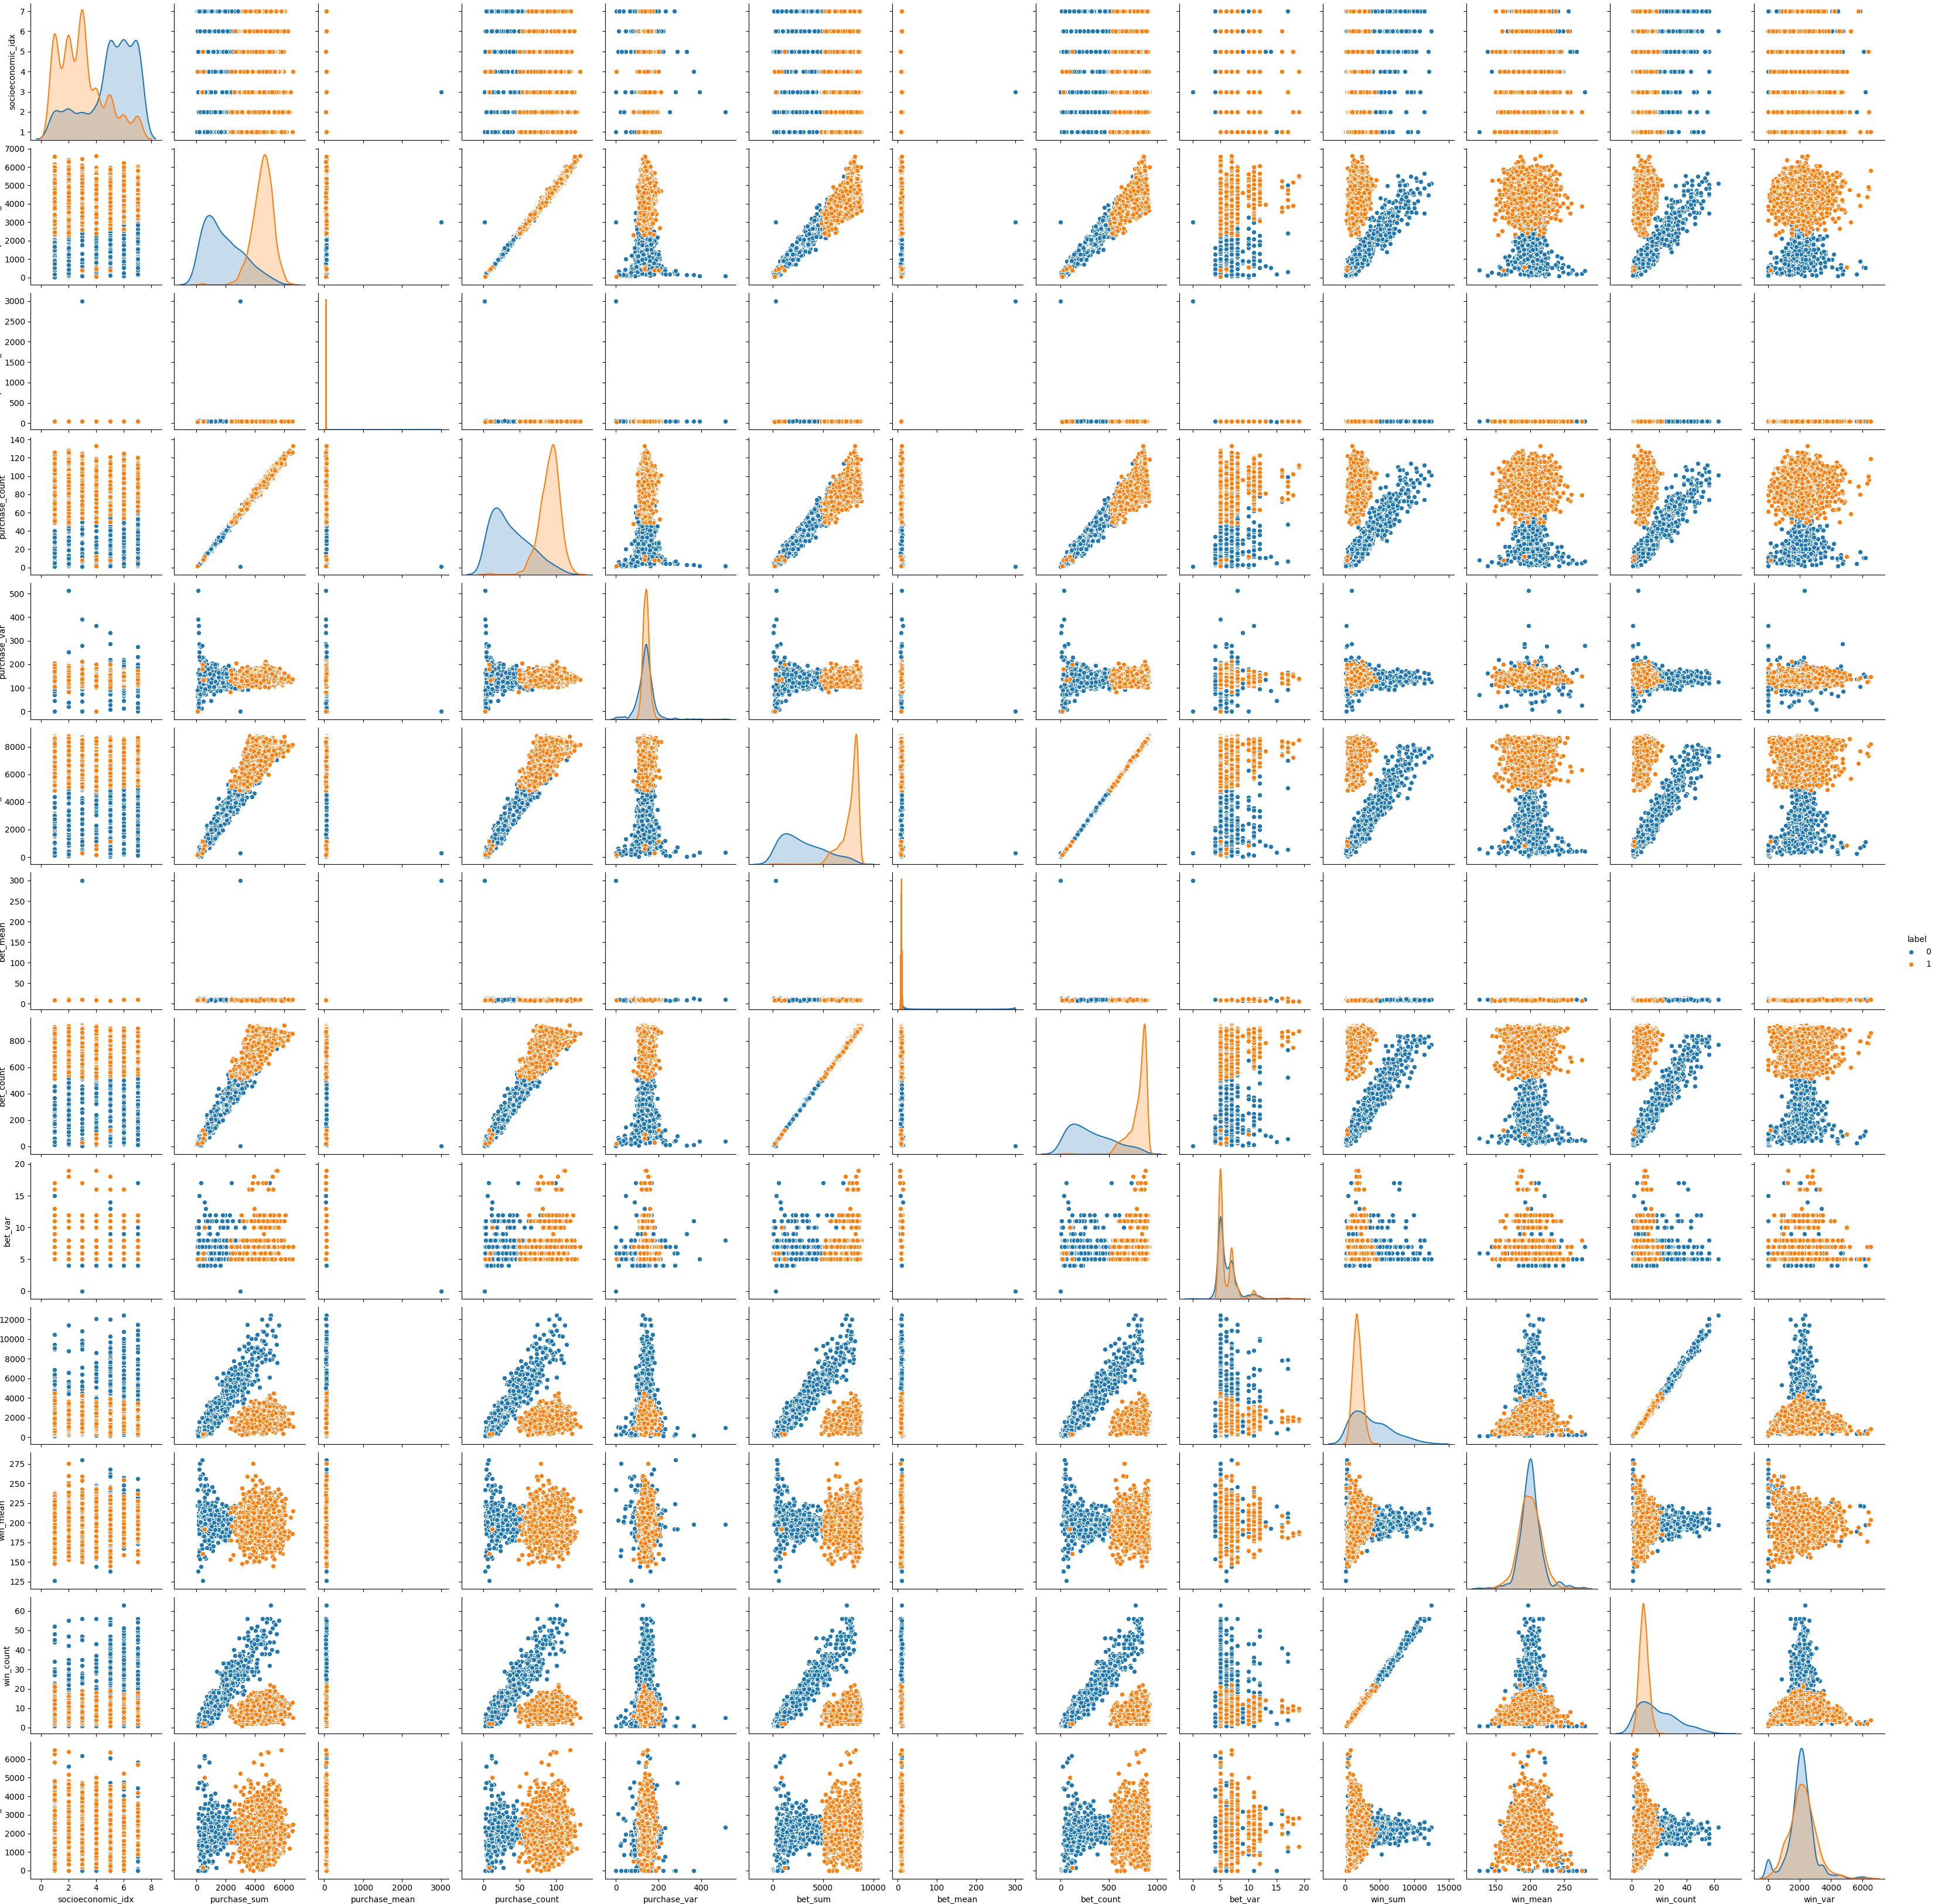

In [18]:
from IPython.display import display, HTML

# Display the `histograms` artifact
display(HTML('<h3>Histograms</h3>'), HTML(describe_run.outputs['histograms']))


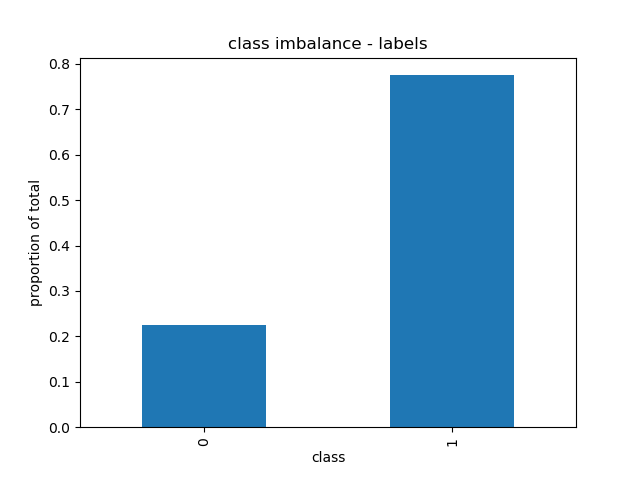

In [19]:
# Display the `imbalance` artifact
display(HTML('<h3>Imbalance<h3>'),
        HTML(filename=describe_run.outputs['imbalance']))


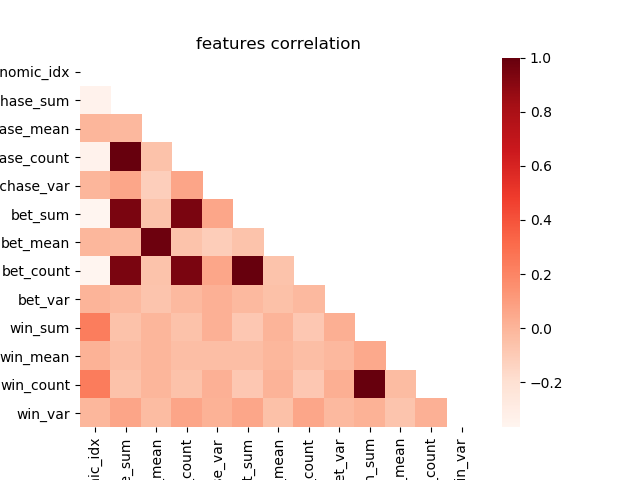

In [20]:
# Display the `correlation` artifact
display(HTML('<h3>Correlation Matrix<h3>'),
        HTML(filename=describe_run.outputs['correlation']))

## Step 4: Run Model Training at Scale <a id="gs-step-run-model-training"></a>


#### Add a Training Function <a id="gs-train-model-add-func"></a>


In [21]:
project.set_function('hub://sklearn_classifier', 'train')
train = project.func('train').apply(mount_v3io())

#### Run a Model-Training Task <a id="gs-train-model-run-task"></a>


In [22]:
# Configure the models to train
models = ["sklearn.ensemble.RandomForestClassifier", 
          "sklearn.linear_model.LogisticRegression",
          "sklearn.ensemble.AdaBoostClassifier"]

In [23]:
# Create a training task
train_task = NewTask(name="train",
                     params={"sample": -1,
                             "label_column": "label",
                             "test_size": 0.10},
                     inputs={"dataset": snapshot_data_run.outputs['snapshot_dataset']})

# Run the training task
train_run = train.run(train_task.with_hyper_params({'model_pkg_class': models},
                                                   selector='max.accuracy'),
                      artifact_path=artifact_path)

> 2020-08-03 16:30:03,556 [info] starting run train uid=0f5cdc89a3ad47869c84b748e22033ba  -> http://mlrun-api:8080
> 2020-08-03 16:30:03,781 [info] Job is running in the background, pod: train-jbjnv
> 2020-08-03 16:30:17,688 [info] best iteration=1, used criteria max.accuracy
> 2020-08-03 16:30:18,355 [info] run executed, status=completed
final state: succeeded


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...e22033ba,0,Aug 03 16:30:09,completed,train,v3io_user=michaelkkind=jobowner=michaelk,dataset,sample=-1label_column=labeltest_size=0.1,best_iteration=1accuracy=0.9983277591973244test-error=0.0016722408026755853rocauc=0.9993820621468927brier_score=0.0032613712374581936f1-score=0.9989572471324296precision_score=1.0recall_score=0.9979166666666667,test_setprobability-calibrationconfusion-matrixfeature-importancesprecision-recall-binaryroc-binarymodeliteration_results


to track results use .show() or .logs() or in CLI: 
!mlrun get run 0f5cdc89a3ad47869c84b748e22033ba --project default , !mlrun logs 0f5cdc89a3ad47869c84b748e22033ba --project default
> 2020-08-03 16:30:23,064 [info] run executed, status=completed


### Review the Run Output <a id="gs-train-model-run-output-review"></a>



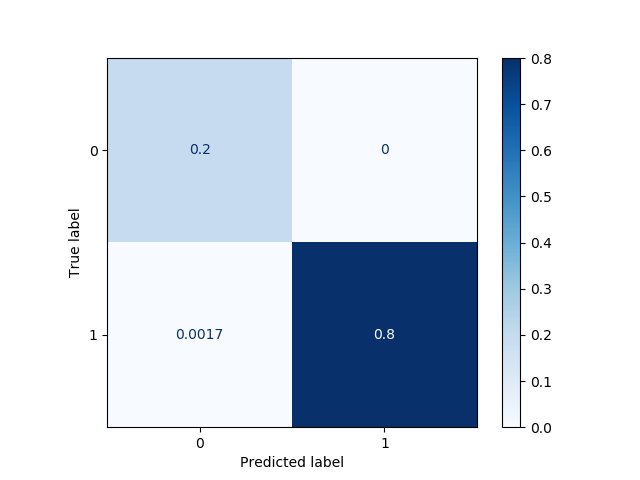


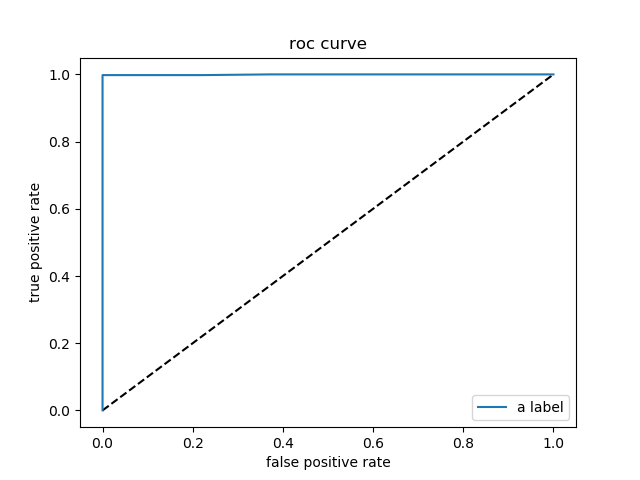

In [24]:
# Display the name of the selected model
display(HTML(f'<b>Best model:</b> '
             f'{models[train_run.outputs["best_iteration"]-1]}'))

# Display the accuracy for the optimal run iteration
display(HTML(f'<b>Accuracy:</b> {train_run.outputs["accuracy"]}'))

# Display HTML output artifacts
display(HTML('<h3>Confusion Matrix:</h3>'),
        HTML(filename=train_run.outputs['confusion-matrix']))
display(HTML('<h3>ROC Curve:</h3>'), HTML(filename=train_run.outputs['roc-binary']))

## Step 5: Test Your Model <a id="gs-step-test-model"></a>


In [25]:
project.set_function('hub://test_classifier', 'test')
test = project.func('test').apply(mount_v3io())

#### Run a Model-Testing Task <a id="gs-test-model-run-task"></a>


In [26]:
test_task = NewTask(name="test",
                    params={"label_column": "label",
                            "plots_dest": path.join("plots", "test")},
                    inputs={"models_path": train_run.outputs['model'],
                            "test_set": train_run.outputs['test_set']}
                    )
test_run = test.run(test_task,
                    artifact_path=artifact_path)

> 2020-08-03 16:31:18,946 [info] starting run test uid=10b26c8756534ab7bff8e815f9822ea5  -> http://mlrun-api:8080
> 2020-08-03 16:31:19,172 [info] Job is running in the background, pod: test-72qsk
> 2020-08-03 16:31:27,416 [info] run executed, status=completed
final state: succeeded


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...f9822ea5,0,Aug 03 16:31:25,completed,test,v3io_user=michaelkkind=jobowner=michaelkhost=test-72qsk,models_pathtest_set,label_column=labelplots_dest=plots/test,accuracy=1.0test-error=0.0rocauc=1.0brier_score=0.0007078947368421054f1-score=1.0precision_score=1.0recall_score=1.0,probability-calibrationconfusion-matrixfeature-importancesprecision-recall-binaryroc-binarytest_set_preds


to track results use .show() or .logs() or in CLI: 
!mlrun get run 10b26c8756534ab7bff8e815f9822ea5 --project default , !mlrun logs 10b26c8756534ab7bff8e815f9822ea5 --project default
> 2020-08-03 16:31:31,448 [info] run executed, status=completed


### Review the Run Output <a id="gs-test-model-run-output-review"></a>



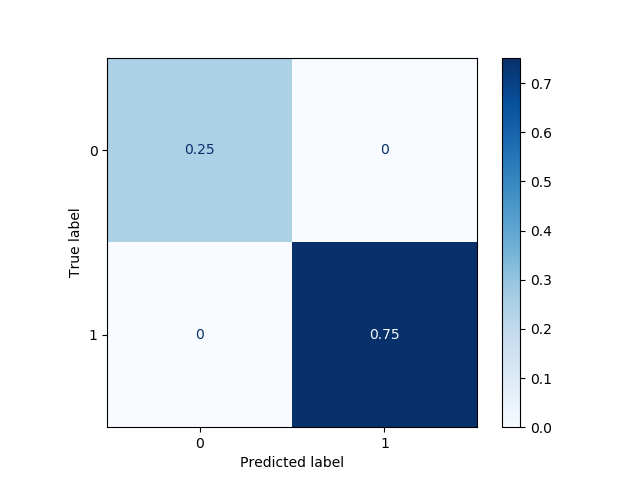


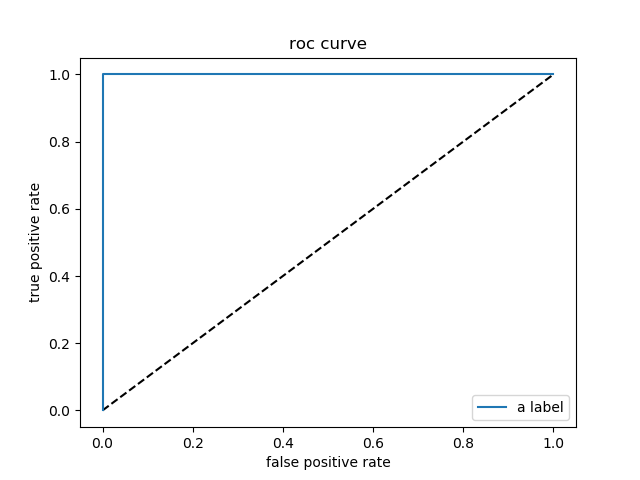

In [27]:
# Display the model accuracy
display(HTML(f'<b>Test Accuracy:</b> {test_run.outputs["accuracy"]}'))

# Display HTML output artifacts
display(HTML("<h3>Confusion matrix:</h3>"),
        HTML(filename=test_run.outputs['confusion-matrix']))
display(HTML("<h3>ROC Curve:</h3>"), HTML(filename=test_run.outputs['roc-binary']))

## Step 6: Save project<a id="gs-step-create-n-run-ml-pipeline"></a>


In [28]:
project.save(path.join(project_path, 'project.yaml'))